## Chapter 11: New Data Types in Julia

In [1]:
struct Mystruct 
  num::Integer 
  str::String
end

In [2]:
m=Mystruct(11,"hello")

Mystruct(11, "hello")

In [3]:
m.num

11

In [4]:
m.str

"hello"

In [5]:
fieldnames(Mystruct)

(:num, :str)

In [6]:
fieldnames(m)

LoadError: MethodError: no method matching fieldnames(::Mystruct)
Closest candidates are:
  fieldnames(!Matched::Core.TypeofBottom) at reflection.jl:175
  fieldnames(!Matched::Type{var"#s9"} where var"#s9"<:Tuple) at reflection.jl:177
  fieldnames(!Matched::DataType) at reflection.jl:172
  ...

In [7]:
mutable struct MutableStruct
  a::Float64
  b::Integer
end

In [8]:
s = MutableStruct(1,2)

MutableStruct(1.0, 2)

In [9]:
s.a=4.5

4.5

In [10]:
m.str = "goodbye"

LoadError: setfield! immutable struct of type Mystruct cannot be changed

In [11]:
ranks = ['A','2','3','4','5','6','7','8','9','T','J','Q','K'];
suits = ['\u2660','\u2661','\u2662','\u2663']

4-element Array{Char,1}:
 '♠': Unicode U+2660 (category So: Symbol, other)
 '♡': Unicode U+2661 (category So: Symbol, other)
 '♢': Unicode U+2662 (category So: Symbol, other)
 '♣': Unicode U+2663 (category So: Symbol, other)

In [12]:
struct Card
    rank::Integer
    suit::Integer
end

In [13]:
c = Card(3,2)

Card(3, 2)

In [14]:
Base.show(io::IO, c::Card) = print(io, string(ranks[c.rank],suits[c.suit]))

In [15]:
struct Card
  rank::Int
  suit::Int
  Card(r::Int,s::Int)=(1<=r<=13) ? ( (1<=s<=4) ? new(r,s) :
    throw(ArgumentError("The argument for suit must be between 1 and 4"))) :
    throw(ArgumentError("The argument for rank must be between 1 and 13")) 
  Card(i::Int) = !(1<=i<=52) ?
    throw(ArgumentError("The argument must be an integer between 1 and 􏰍52")) :
    i%13==0 ? new(13,div(i,13)) : new(i%13,div(i,13)+1) 
end

LoadError: invalid redefinition of type Card

In [16]:
c = Card(3,2)

3♡

In [17]:
Card(45)

LoadError: MethodError: no method matching Card(::Int64)
Closest candidates are:
  Card(::Integer, !Matched::Integer) at In[12]:2
  Card(::Any, !Matched::Any) at In[12]:2

In [18]:
struct Hand
    cards::Array{Card,1}
end

In [19]:
h=Hand([Card(2,3),Card(12,1),Card(10,1),Card(10,4),Card(5,2)])

Hand(Card[2♢, Q♠, T♠, T♣, 5♡])

In [20]:
Base.show(io::IO,h::Hand) = print(io, string("[",join(h.cards,", "),"]"))

In [21]:
h

[2♢, Q♠, T♠, T♣, 5♡]

In [22]:
function is_full_house(h::Hand)
    ranks = sort(map(c->c.rank, h.cards))
    return (ranks[1]==ranks[2]==ranks[3] && ranks[4]==ranks[5]) ||
        (ranks[1]==ranks[2] && ranks[3]==ranks[4]==ranks[5])
end

is_full_house (generic function with 1 method)

In [23]:
is_full_house(h)

false

In [24]:
is_full_house(Hand([Card(11),Card(11),Card(24),Card(3),Card(16)]))

LoadError: MethodError: no method matching Card(::Int64)
Closest candidates are:
  Card(::Integer, !Matched::Integer) at In[12]:2
  Card(::Any, !Matched::Any) at In[12]:2

In [25]:
struct Polynomial{T <: Number}
  coeffs::Vector{T}
end

In [26]:
function Base.show(io::IO, p::Polynomial)
  str = ""
  for i = 1:length(p.coeffs)
      str = string(str,p.coeffs[i],"x^",i-1,i<length(p.coeffs) ? "+" : "")
  end
  print(io, str)
end

In [27]:
p = Polynomial([1,2,3])

1x^0+2x^1+3x^2

In [28]:
for (c,i) in enumerate(p.coeffs)
    println("$c $i")
end

1 1
2 2
3 3


### Develop a Polynomial Type

In [29]:
struct Polynomial{T <: Number} 
    coeffs::Vector{T}
end

In [30]:
poly1=Polynomial([1,2,3])
poly2=Polynomial([1.0,2.0,3.0])
poly3=Polynomial([2//3,3//4,5//8])
poly4=Polynomial([im,2+0im,3-2im,-im])
poly5=Polynomial([n for n=1:6])

1x^0+2x^1+3x^2+4x^3+5x^4+6x^5

In [31]:
function Base.show(io::IO, p::Polynomial) 
  str = ""
  for i = 1:length(p.coeffs)
    str = string(str,p.coeffs[i],"x^",i-1,i<length(p.coeffs) ? "+" : "")
  end
  print(io, str)
end

In [32]:
poly5

1x^0+2x^1+3x^2+4x^3+5x^4+6x^5

In [33]:
function eval(p::Polynomial,x::Number)
  result = p.coeffs[end] 
  for i=length(p.coeffs)-1:-1:1
    result = x*result+p.coeffs[i]
  end
  result
end

eval (generic function with 2 methods)

In [44]:
function eval(poly::Polynomial{T},x::S) where {S <: Number, T <: Number}
  reduce((val,i)->val + poly.coeffs[i]*x^(i-1),1:length(poly.coeffs),init=zero(T))
end

eval (generic function with 2 methods)

In [45]:
eval(poly5,3)

2005

In [21]:
methods(eval)

# 2 methods for generic function "eval":
[1] eval(p::Polynomial, x::Number) in Main at In[20]:1
[2] eval(x) in Base.MainInclude at client.jl:467

In [22]:
eval(poly1,0)

1

In [23]:
eval(poly1,-1)

2

In [24]:
subtypes(Number)

2-element Array{Any,1}:
 Complex
 Real

In [25]:
Float64 <: Number

true

In [27]:
using Plots,RecipesBase

In [30]:
@recipe function f(poly::Polynomial,xmin::Number=-2,xmax::Number=2) 
  legend -->  false
  linecolor -->  :green
  xpts = LinRange(xmin,xmax,200)
  ypts = map(x->eval(poly,x),xpts)
  xpts,ypts
end

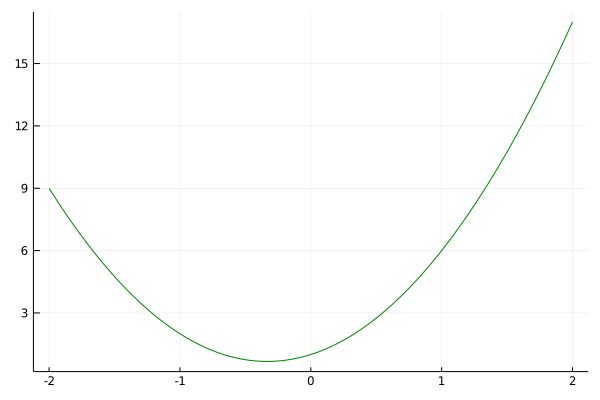

In [31]:
plot(poly1)

In [27]:
savefig("../images/ch11/plot55.png")

### Develop a Root datatype

In [13]:
using ForwardDiff

┌ Info: Precompiling ForwardDiff [f6369f11-7733-5829-9624-2563aa707210]
└ @ Base loading.jl:1278


In [14]:
struct Root
  root::Float64
  x_eps::Float64
  f_eps::Float64
  num_steps::Int
  converged::Bool
  max_steps::Int
end

In [15]:
function Base.show(io::IO,r::Root)
  if(r.converged)
    str = string("The root is approximately x̂ = ",r.root," \n")
    str = string(str,"An estimate for the error is ",r.x_eps,"\n")
    str = string(str,"with f(x̂) = ",r.f_eps,"\n")
    str = string(str,"which took ",r.num_steps," steps")
  else
    str = string("The root was not found within ",r.max_steps," steps.\n");
    str = string(str,"Currently, the root is approximately x̂ = ",r.root," \n")
    str = string(str,"An estimate for the error is ",r.x_eps,"\n")
    str = string(str,"with f(x̂) = ",r.f_eps,"\n")
  end
  print(io,str)
end

In [16]:
function newton(f::Function,  x0::Real)
  local n=0
  local dx=f(x0)/ForwardDiff.derivative(f,x0)
  while abs(dx)>1e-6
    x0 = x0-dx
    dx = f(x0)/ForwardDiff.derivative(f,x0)
    n += 1 
    if n==10  # if too many steps are taken, break out of the while loop
      return Root(x0,dx,f(x0),n,false,10)
    end
  end
  Root(x0,dx,f(x0),n,true,10)
end

newton (generic function with 1 method)

In [17]:
r = newton(x->x^2-2,1)

The root is approximately x̂ = 1.4142135623746899 
An estimate for the error is 1.5947429102833119e-12
with f(x̂) = 4.510614104447086e-12
which took 4 steps

In [22]:
r = newton(x->x^2+1,2)

The root was not found within 10 steps.
Currently, the root is approximately x̂ = 2.4008803928468465 
An estimate for the error is 1.4086971347905715
with f(x̂) = 6.764226660756428
